# Rough

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [3]:
import pandas as pd

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
    get_text_annotation
)

from poly2.utils import get_dispersal_kernel, trait_vec
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture
from poly2.simulator import SimulatorOneTrait

In [6]:
df = pd.read_csv('../outputs/combined/fung_scan.csv')

In [93]:
def monotonic_yld(df):
    du = df.sort_values('dose')
    diffs = du.yld.diff()
    return sum(diffs>0)

In [66]:
diffs = (
    df
    .groupby(['run', 'year'])
    .apply(monotonic_yld)
    .reset_index()
    .rename(columns={0: 'n_pos_diff'})
)


In [67]:
dd2 = (
    diffs.set_index('run').join(df.groupby('run').mean().reset_index().loc[:, ['a', 'b', 'mu']]).reset_index()
    #.loc[lambda x: x.year==50]
    #.plot.scatter(x='mu', y='n_pos_diff')
)

<AxesSubplot:xlabel='mu', ylabel='n_pos_diff'>

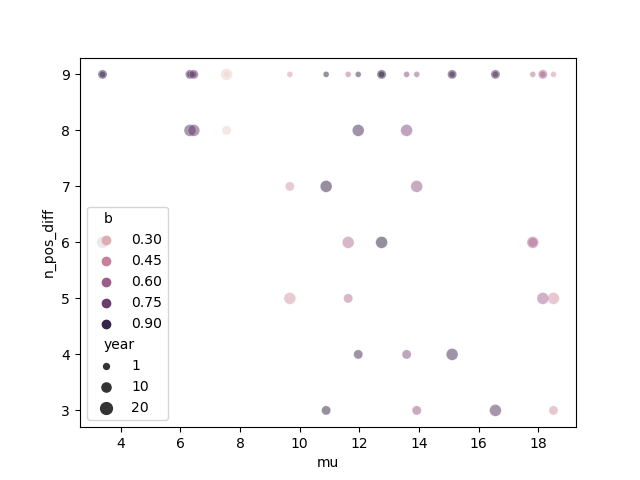

In [92]:
f, ax = plt.subplots()

sns.scatterplot(
    x='mu',
    y='n_pos_diff',
    hue='b',
    size='year',
    data=dd2.loc[lambda x: x.b<1].loc[lambda x: x.year.isin([1,10,20])],
    alpha=0.5,
    #.loc[lambda x: x.year<10],
    #.loc[lambda x: x.year==3],
    ax=ax
)

In [85]:
plt.close('all')

<AxesSubplot:xlabel='year', ylabel='yld'>

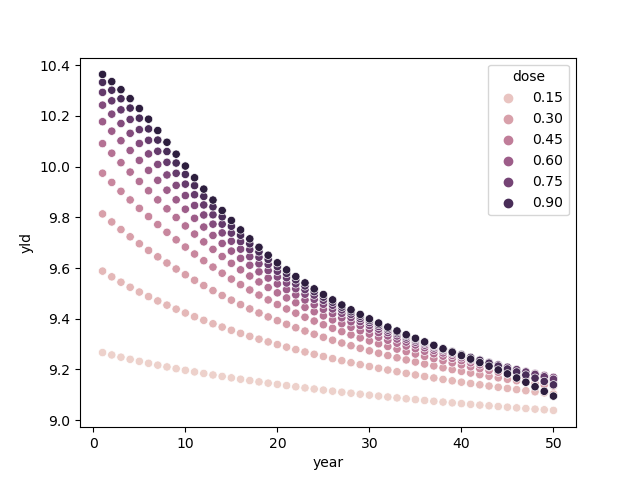

In [59]:
f, ax = plt.subplots()

sns.scatterplot(
    x='year',
    y='yld',
    hue='dose',
    data=df.loc[lambda x: x.run==11],
    ax=ax
)

In [37]:
df.groupby('run').mean().reset_index().head(10)

,run,yld,year,dose,a,b,mu
0,0,9.408858,25.5,0.55,21.952540,14.303787,1.534736
1,1,9.523765,25.5,0.55,24.110535,10.897664,2.212450
2,2,9.316534,25.5,0.55,16.946192,12.917882,1.311840
3,3,9.260484,25.5,0.55,17.503488,17.835460,0.981387
4,4,9.880638,25.5,0.55,38.546510,7.668830,5.026387
5,5,9.287008,25.5,0.55,16.680880,14.406490,1.157873
6,6,9.185803,25.5,0.55,5.870236,1.846772,3.178647
7,7,9.128091,25.5,0.55,7.450408,6.911215,1.078017
8,8,9.326315,25.5,0.55,15.870699,10.776335,1.472736
9,9,9.299639,25.5,0.55,16.767781,13.704390,1.223534
